In [398]:
from nltk.corpus import stopwords 
import nltk
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
%matplotlib inline
import numpy as np 
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')


In [399]:
# Reading data
data = pd.read_csv("enron_test.csv")
df = pd.DataFrame(data)

In [400]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
Date        1000 non-null object
From        1000 non-null object
To          995 non-null object
Subject     698 non-null object
content     1000 non-null object
new_date    1000 non-null object
dtypes: object(6)
memory usage: 47.0+ KB


In [401]:
# The To field has 5 null values and on exploring them we find that 2/5 are repeated and are about DSL installers 
# at Philip ALlen's house, 2 out of remaining 3 are from BLoomberg Power lines about their power consumption.
# We can safely discard them as they dont pertain to Enron industries.
data[data['To'].isnull()]

Date  \
188  Mon, 1 May 2000 03:56:00 -0700 (PDT)    
603  Wed, 13 Dec 2000 08:35:00 -0800 (PST)   
781  Mon, 1 May 2000 03:56:00 -0700 (PDT)    
873  Fri, 7 Jan 2000 16:23:00 -0800 (PST)    
885  Mon, 14 May 2001 09:04:00 -0700 (PDT)   

                                           From   To  \
188  frozenset({'phillip.allen@enron.com'})      NaN   
603  frozenset({'messenger@ecm.bloomberg.com'})  NaN   
781  frozenset({'phillip.allen@enron.com'})      NaN   
873  frozenset({'owner-strawbale@crest.org'})    NaN   
885  frozenset({'messenger@ecm.bloomberg.com'})  NaN   

                          Subject  \
188  Re: DSL- Installs              
603  Bloomberg Power Lines Report   
781  Re: DSL- Installs              
873  NaN                            
885  Bloomberg Power Lines Report   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [402]:
# Dropping the null values from To attribute
data=data.dropna(subset=['To'])

In [403]:
# Cleaning the from and to fields (Removing the 'frozenset' words)
data["From"]= data["From"].str.replace("frozenset", "").str.replace(r'[\({\'\'})\d]+', '')
data["To"]= data["To"].str.replace("frozenset", "").str.replace(r'[\({\'\'})\d]+', '')

In [404]:
# Extracting day and time from the Date field
data['Day'] = data['Date'].str[:3]
data['Time'] = data['new_date'].str[10:]

## Overall Weekly traffic sent and received
Most traffic is received/sent on weekdays and almost negligible on weekends

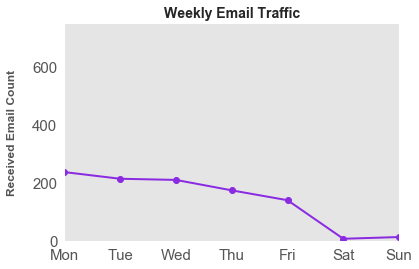

In [405]:
data['Day'] = pd.Categorical(data['Day'], categories= ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'],ordered=True)

# sort by day of the week
count_sorted_by_day = data['Day'].value_counts().sort_index()

plt.figure()
count_sorted_by_day.plot(marker = 'o', color = 'blueviolet', linewidth = 2, ylim = [0,750])
plt.title('Weekly Email Traffic', fontweight = 'bold' ,fontsize = 14)
plt.ylabel("Received Email Count", fontweight = 'bold', labelpad = 15)
plt.grid()

## Hourly email traffic sent/received
Most emails sent/received during the general work hours of 9:00 am to 5:00 pm.

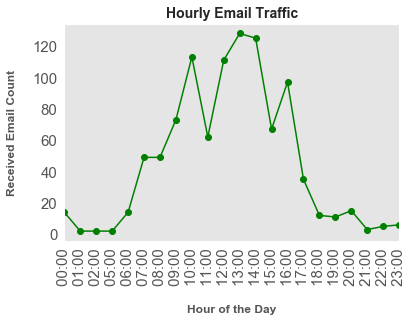

In [406]:
plt.figure()

# splitting only the hour portion in the time column
hour = data['Time'].str.split(':').str[0] + ':00'

# sort by hour of the day - using sort_index for numeric sort
count_sorted_by_hour = hour.value_counts().sort_index()

count_sorted_by_hour.plot(marker = 'o', color = 'green')
plt.title('Hourly Email Traffic', fontsize = 14, fontweight = 'bold')
plt.ylabel("Received Email Count", fontweight = 'bold', labelpad = 15)
plt.xlabel("Hour of the Day", fontweight = 'bold', labelpad = 15)
plt.xticks(range(len(count_sorted_by_hour.index)), count_sorted_by_hour.index)
plt.xticks(rotation=90)
plt.grid()

## Top 15 recipients of emails

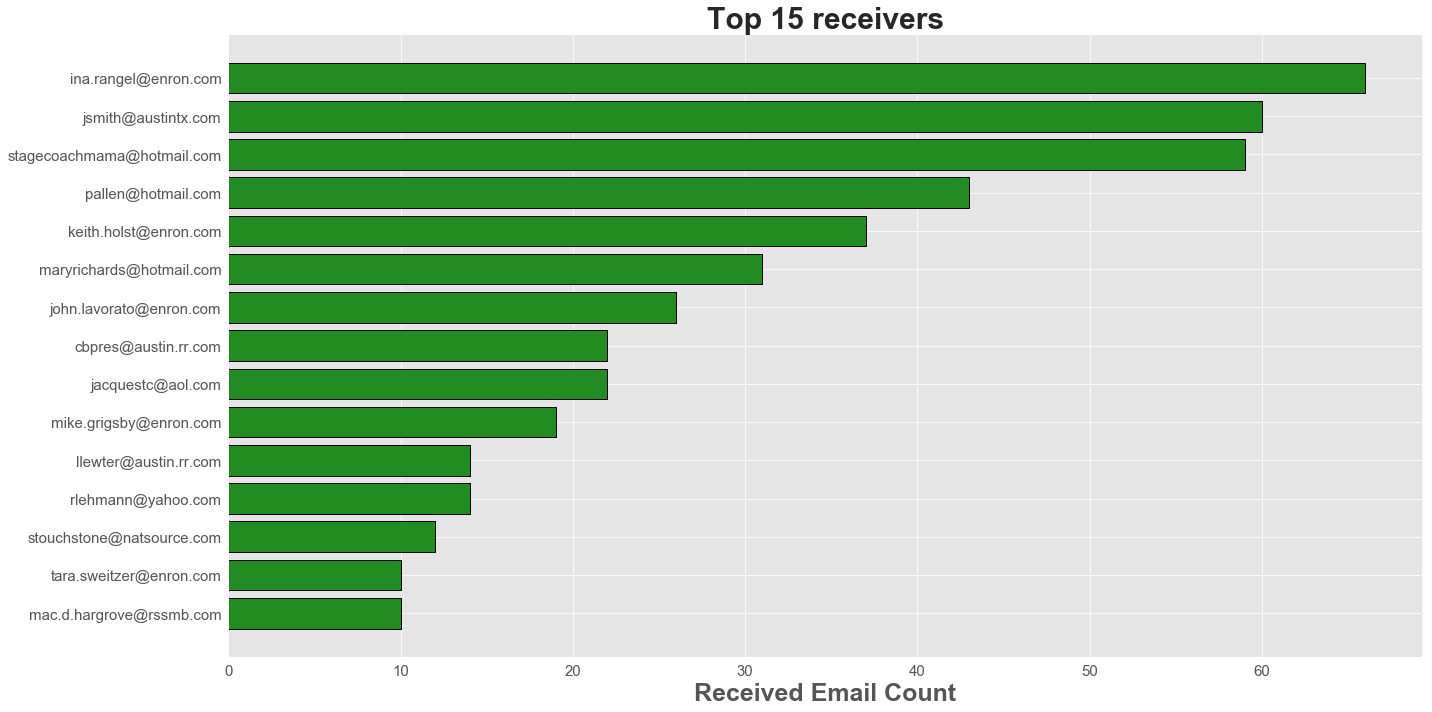

In [407]:
top_15_receivers =  data['To'].value_counts().nlargest(15)
top_15_count = top_15_receivers.values
top_15 = top_15_receivers.index.tolist()

plt.figure(figsize=(20,10))
plt.barh(top_15, top_15_count, color = 'forestgreen', ec = 'black', linewidth = 1.0)
plt.gca().invert_yaxis()
plt.title('Top 15 receivers', fontsize = 30 ,fontweight = 'bold')
plt.xlabel('Received Email Count', fontweight = 'bold', fontsize = 25)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
plt.tight_layout()

## Topics discussed in the emails 

In [408]:
def find_content(text):
    # Cleaning the content to include only the main message body
    index_sub = text.find('Subject') 
    index_des = text.find('Description')
    index_sub = max(0, max(index_sub, index_des))
    text = text[index_sub:]
    index_msg_start =text.find('\n')
    index_msg_start = max(0,index_msg_start)
    text = text[index_msg_start:]
    return text

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
    
def clean(text):
    text = text.lower().replace("\n", " ").replace(r'\w*hou\w*', ' ').replace(r'\w*ect\w*', ' ')
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    # Updating the stop words wrt current context based on most common non-informational words
    stop.update(("to","cc","subject","http","from","sent","forwarded","date", "hou", "ect", "please", "thank", "you", "id", "address", "via", "yes", "need", "time", "mailto","and", "go","want","know", "say", "like","also","would"))
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return text


In [409]:
# Figuring out most discussed topic in the emails

content_processed = " "
for text in data['content']: 
    content_processed+= find_content(text)
clean_text = clean(content_processed)

# Counter(clean_text.split()).most_common(100)

In [410]:
iterStr = [clean_text]
no_features = 50
tf_vectorizer = CountVectorizer(max_df=1, min_df=1, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(iterStr)
tf_feature_names = tf_vectorizer.get_feature_names()
no_topics = 1

In [411]:
#Function to display topics created after LDA
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))


In [412]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=35, learning_method='online', learning_offset=60.,random_state=0).fit(tf)
no_top_words = 35
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
phillip ect com enron gas hou loan cost use project price work power new allen plan mail email market position pm deal unit list pay question look week receive report let year meeting construction make


The topics discussed in the emails deal with following :
Discussing cost for potential new gas project, discussing about prices, unit power, deciding plan of action, loans, definitely about arranging meetings  

## Top 15 Receivers' hourly traffic rate of receiving emails 
Most emails are received during the office hours from 8:30 am to 5:00 pm. After 5:00pm, there is a decreasing trend in the email activity and that can be attributed to the end of normal office hours.

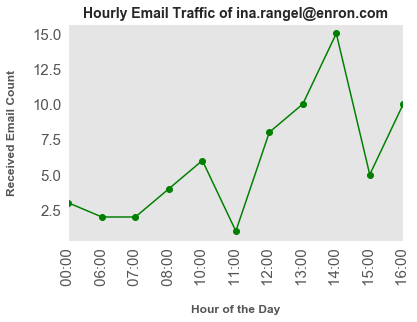

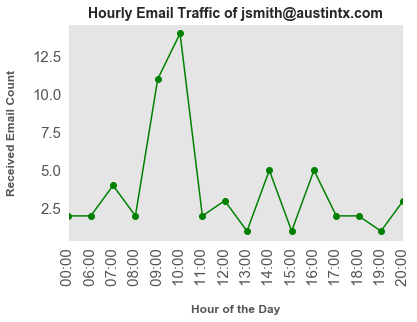

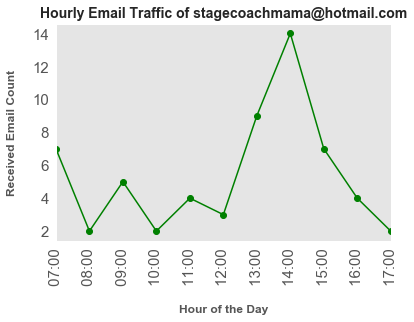

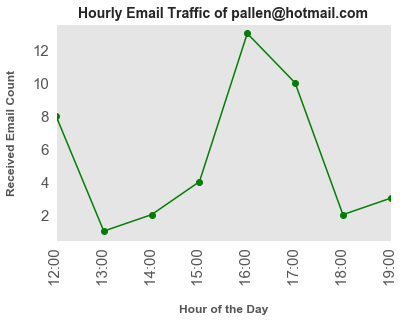

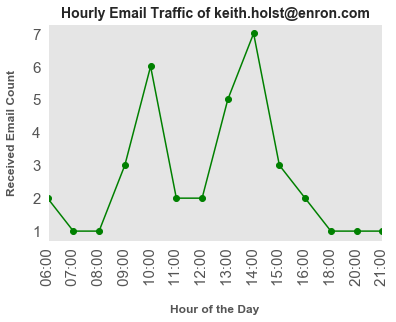

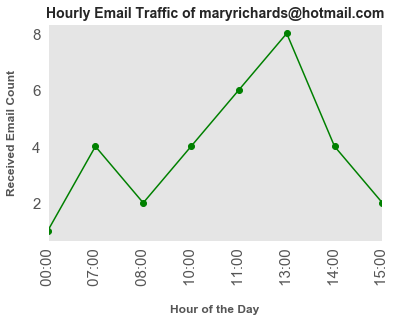

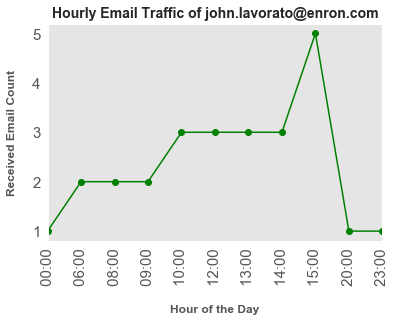

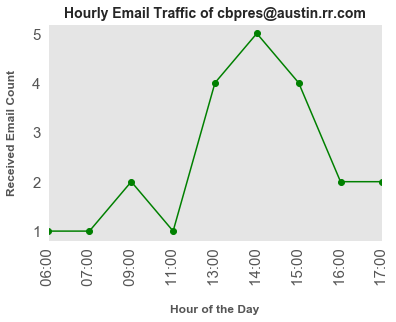

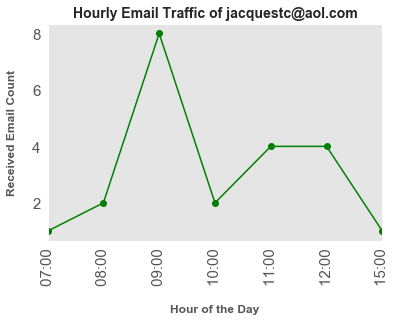

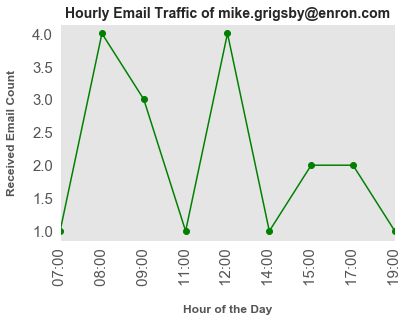

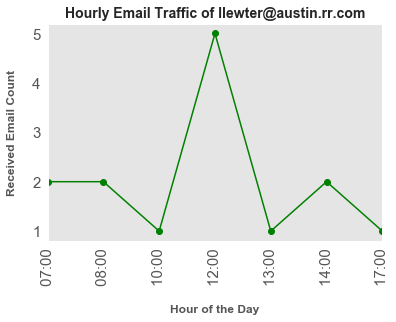

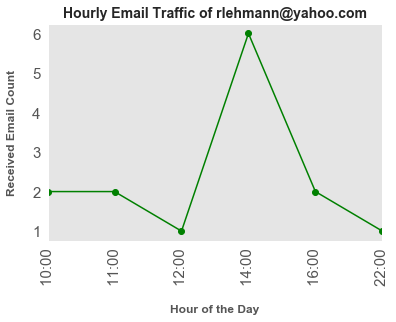

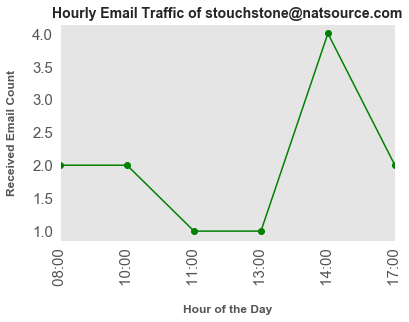

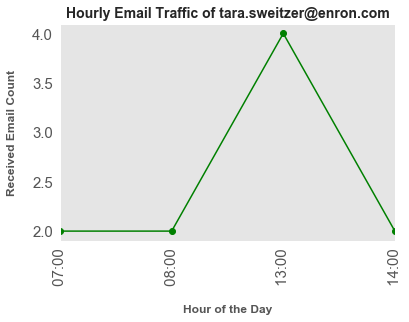

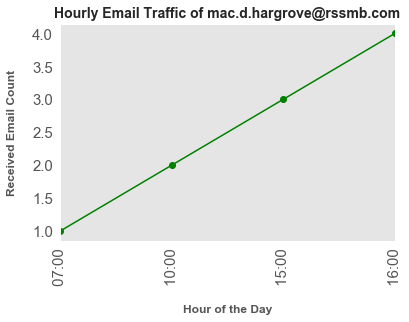

In [413]:
# Top 15 Receivers hourly traffic rate
for person in top_15:

    data_sub = data[data['To']== person]
    plt.figure()

    # Getting hour portion of time
    hour = data_sub['Time'].str.split(':').str[0] + ':00'

    # using sort_index for numeric sort to sort per hour
    count_sorted_by_hour = hour.value_counts().sort_index()

    count_sorted_by_hour.plot(marker = 'o', color = 'green')
    plt.title('Hourly Email Traffic of '+person, fontsize = 14, fontweight = 'bold')
    plt.ylabel("Received Email Count", fontweight = 'bold', labelpad = 15)
    plt.xlabel("Hour of the Day", fontweight = 'bold', labelpad = 15)
    plt.xticks(range(len(count_sorted_by_hour.index)), count_sorted_by_hour.index)
    plt.xticks(rotation=90)
    plt.grid()


## Weekly email traffic received by the top 15 recipients 
Email activity is high during weekdays and very low during the weekends. One of the recipients showing a little high traffic on weekends seems like the personal email (pallen@hotmail.com) of the sender( Phillip Allen) and thus we can safely discard its behavior during concluding the above fact. It only seems fair for a person to use his personal email no matter whether it is weekday or weekend.

C:\Users\Prachi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Prachi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Prachi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

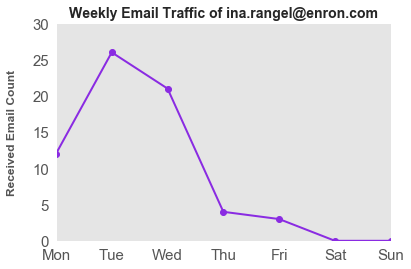

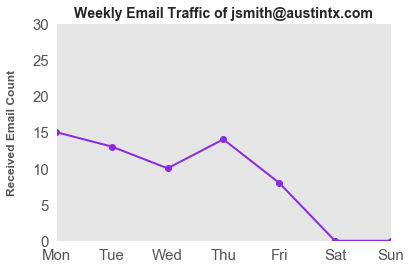

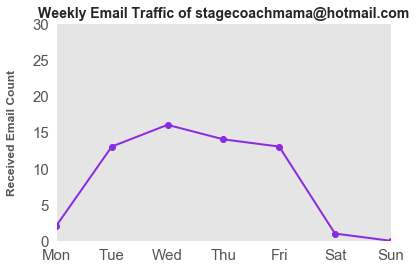

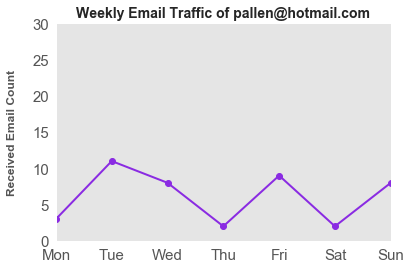

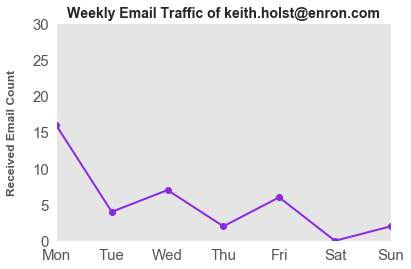

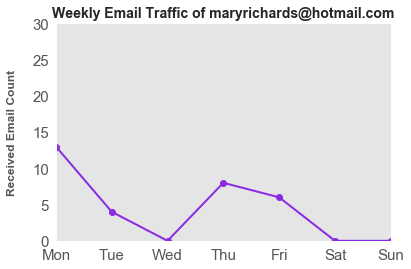

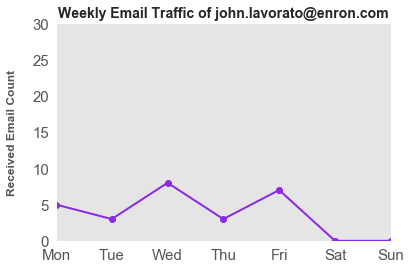

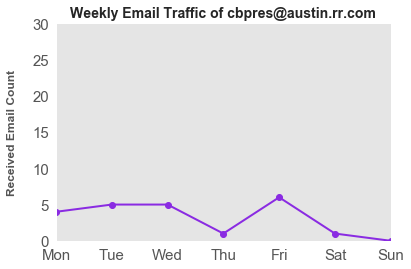

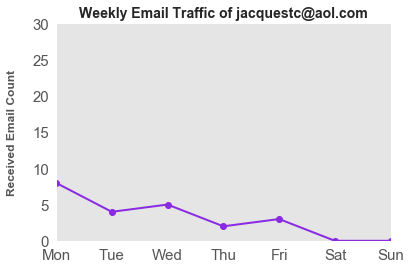

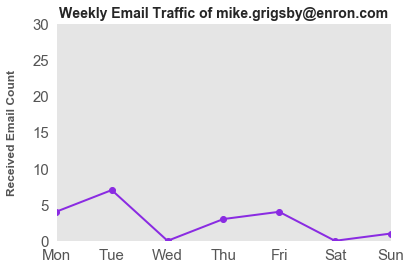

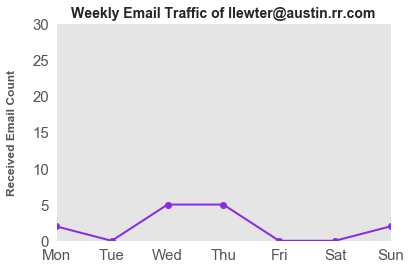

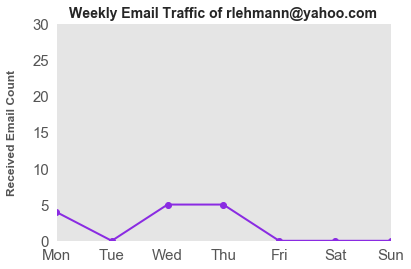

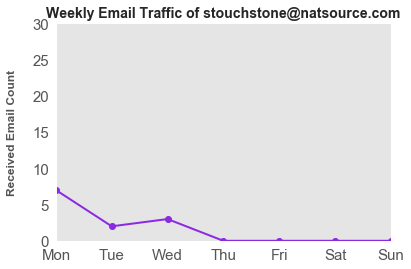

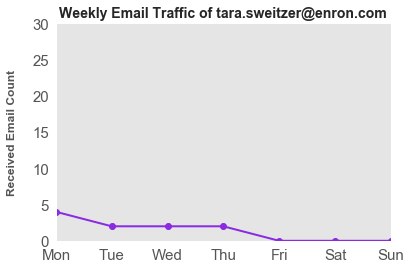

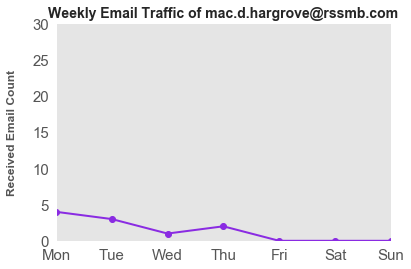

In [414]:
for person in top_15:
    data_sub = data[data['To']== person]
    data_sub['Day'] = pd.Categorical(data_sub['Day'], categories= ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'],ordered=True)

    # sort by day of the week
    count_sorted_by_day = data_sub['Day'].value_counts().sort_index()

    plt.figure()
    count_sorted_by_day.plot(marker = 'o', color = 'blueviolet', linewidth = 2, ylim = [0,30])
    plt.title('Weekly Email Traffic of '+person, fontweight = 'bold' ,fontsize = 14)
    plt.ylabel("Received Email Count", fontweight = 'bold', labelpad = 15)
    plt.grid()

## Determining companies receiving most emails based on domain of To attribute

In [415]:
# Extracting sender and recipient domain companies using the email domains
data['Sender_Company'] = data['From'].str.split('@').str[1].str.split('.').str[0]
data['Receiver_Company'] = data['To'].str.split('@').str[1].str.split('.').str[0]
# As the sender is majorly Phillip Allen from enron we can safely discard others
data['Sender_Company'].value_counts()
data_send_enron = data[data['Sender_Company']=='enron']
# data_send_enron.to_csv (r'C:\Users\Prachi\Desktop\data_enron3.csv', index = False, header=True)

### Please visit the following link to see some visualizations seen above and the analysis for subtopic 7
https://public.flourish.studio/story/467549/

## Insights

### The data represents the email activity of majorly one person named Phillip Allen so all the conclusions drawn above work with respect to him.

### Phillip Allen emails mostly to the following people:
     - Ina Rangel
     - J Smith
     - Stagecoachmama and 
### - pallen (which can be accounted as his personal email account owing to most emails that are not new conversations but are just forwarded emails, hourly activity starts after 4:00 pm and accounts for emails on weekends.

### Most of the emails are sent within the organization suggesting the data represents majorly work related emails,  and another major chunk corresponding use of personal email, and conversations with different clients or services used by Phillip Allen.

### Most emails are sent during the time period of 9:00 am to 4:00 pm, which is normal work hours. Therefore, this timeframe is perfect if you want to get quick and timely responses. Also, making sure that you email during weekdays mostly from Monday to Friday, a response is highly likely.

### Most topics discussed in the email contents are about scheduling meetings, new projects, about power and prices, gas, loan
